In [3]:
# use this notebook to compare the zero-shot and fine-tuned performance of Sundial model
import os
import torch
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from ainode.core.model.sundial.modeling_sundial import SundialForPrediction
from ainode.core.training.notebooks.max_heap import MaxHeap

# not a bad config
num_samples = 10
lookback_length = 1440
prediction_length = 96

model_path = "/data/yongzao/timecho-ainode/iotdb-core/ainode/ainode/core/data/ainode/models/weights"
raw_model_id = "sundial"
fine_tune_model_id = "sundialHUMIFULL3"

dataset_path = "/data/yongzao/dataset/demo-set"
dataset_file_name = "weather.csv"
value_path = "root.eg.weather.s20"

In [4]:
# load model and dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# refactor the following path to your own environment

raw_model = SundialForPrediction.from_pretrained(os.path.join(model_path, raw_model_id))
raw_model = raw_model.to(device)
fine_tune_model = SundialForPrediction.from_pretrained(
    os.path.join(model_path, fine_tune_model_id)
)
fine_tune_model = fine_tune_model.to(device)
print(next(raw_model.parameters()).device, next(fine_tune_model.parameters()).device)
# refactor the following path to your own environment

df = pd.read_csv(os.path.join(dataset_path, dataset_file_name))
value = torch.tensor(df[value_path].values, dtype=torch.float32)
value = value.to(device)
print(value.device)

cuda:0 cuda:0
cuda:0


In [14]:
import time

num_samples = 1
lookback_length = 2880
prediction_length = 1440
index = 4000 - lookback_length
seqs = value[index : (index + lookback_length)].unsqueeze(0)
start_time = time.perf_counter()
for i in range(300):
    output_raw = raw_model.generate(
        seqs, max_new_tokens=prediction_length, num_samples=num_samples, revin=True
    )
end_time = time.perf_counter()
execution_time = (end_time - start_time) * 1000
print(f"inference cost: {execution_time / 300.0:.2f}ms")

inference cost: 106.00ms


Sundial zero-shot MSE Loss: 75.8092, MAE Loss: 6.7632
Sundial fine-tuned MSE Loss: 71.7443, MAE Loss: 6.5551
Improvement of MSE Loss: 5.36%
Improvement of MAE Loss: 3.08%


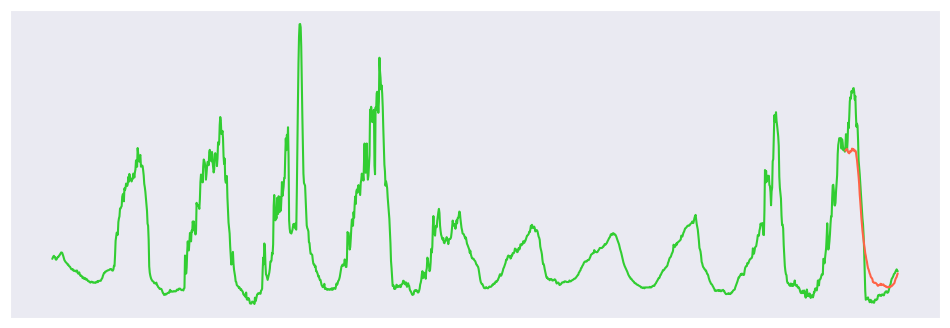

In [16]:
import random
import torch
import numpy as np

fix_seed = 2021
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

raw_model = SundialForPrediction.from_pretrained(os.path.join(model_path, raw_model_id))
raw_model = raw_model.to(device)
fine_tune_model = SundialForPrediction.from_pretrained(
    os.path.join(model_path, fine_tune_model_id)
)
fine_tune_model = fine_tune_model.to(device)

# Sample visualization
start = 15000
# prepare input & ground truth
seqs = value[start : (start + lookback_length)].unsqueeze(0)
truth = value[start + lookback_length : (start + lookback_length + prediction_length)]
# generate forecast
output_raw = raw_model.generate(
    seqs, max_new_tokens=prediction_length, num_samples=num_samples, revin=True
)
output_raw = output_raw[0].mean(dim=0)
output_fine_tune = fine_tune_model.generate(
    seqs, max_new_tokens=prediction_length, num_samples=num_samples, revin=True
)
output_fine_tune = output_fine_tune[0].mean(dim=0)
raw_mse_loss = F.mse_loss(output_raw, truth, reduction="none").mean(dim=-1).sum()
raw_mae_loss = F.l1_loss(output_raw, truth, reduction="none").mean(dim=-1).sum()
fine_tune_mse_loss = (
    F.mse_loss(output_fine_tune, truth, reduction="none").mean(dim=-1).sum()
)
fine_tune_mae_loss = (
    F.l1_loss(output_fine_tune, truth, reduction="none").mean(dim=-1).sum()
)
print(f"Sundial zero-shot MSE Loss: {raw_mse_loss:.4f}, MAE Loss: {raw_mae_loss:.4f}")
print(
    f"Sundial fine-tuned MSE Loss: {fine_tune_mse_loss:.4f}, MAE Loss: {fine_tune_mae_loss:.4f}"
)
print(
    f"Improvement of MSE Loss: {((raw_mse_loss - fine_tune_mse_loss) / raw_mse_loss * 100):.2f}%"
)
print(
    f"Improvement of MAE Loss: {((raw_mae_loss - fine_tune_mae_loss) / raw_mae_loss * 100):.2f}%"
)
# visualize
plt.figure(figsize=(12, 4))
plt.xticks([])
plt.yticks([])
plt.plot(
    df[value_path][start : (start + lookback_length + prediction_length)],
    color="limegreen",
    label="Groundtruth",
)
plt.plot(
    range(start + lookback_length, start + lookback_length + prediction_length),
    output_raw.cpu(),
    color="tomato",
    label="Zero-shot Prediction",
)
# plt.plot(range(start + lookback_length, start + lookback_length + prediction_length), output_fine_tune.cpu(), color="royalblue", label="Fine-tune Prediction")
# plt.legend()
# plt.grid()
plt.show()

In [12]:
# compare zero-shot and fine-tuned loss
heap = MaxHeap()
start_index = 18000 - lookback_length
# end_index = start_index + 10
end_index = 20000 - lookback_length - prediction_length

mse_improve_list = []
raw_total_mse_loss = torch.tensor(0.0).to(device)
raw_total_mae_loss = torch.tensor(0.0).to(device)
fine_tune_total_mse_loss = torch.tensor(0.0).to(device)
fine_tune_total_mae_loss = torch.tensor(0.0).to(device)
total_count = torch.tensor(0.0).to(device)
for i in range(start_index, end_index):
    # prepare input & ground truth
    seqs = value[i : (i + lookback_length)].unsqueeze(0)
    truth = value[i + lookback_length : (i + lookback_length + prediction_length)]

    # generate forecast
    output_raw = raw_model.generate(
        seqs, max_new_tokens=prediction_length, num_samples=num_samples, revin=True
    )
    output_raw = output_raw[0].mean(dim=0)
    output_fine_tune = fine_tune_model.generate(
        seqs, max_new_tokens=prediction_length, num_samples=num_samples, revin=True
    )
    output_fine_tune = output_fine_tune[0].mean(dim=0)

    # sum the loss
    cur_raw_mse_loss = (
        F.mse_loss(output_raw, truth, reduction="none").mean(dim=-1).sum()
    )
    cur_raw_mae_loss = F.l1_loss(output_raw, truth, reduction="none").mean(dim=-1).sum()
    cur_fine_tune_mse_loss = (
        F.mse_loss(output_fine_tune, truth, reduction="none").mean(dim=-1).sum()
    )
    cur_fine_tune_mae_loss = (
        F.l1_loss(output_fine_tune, truth, reduction="none").mean(dim=-1).sum()
    )

    mse_improve = (cur_raw_mse_loss - cur_fine_tune_mse_loss) / cur_raw_mse_loss * 100
    mse_improve_list.append(mse_improve.item())
    heap.push(i, mse_improve.item())

    raw_total_mse_loss += cur_raw_mse_loss
    raw_total_mae_loss += cur_raw_mae_loss
    fine_tune_total_mse_loss += cur_fine_tune_mse_loss
    fine_tune_total_mae_loss += cur_fine_tune_mae_loss
    total_count += 1

    if i % 100 == 0:
        print(f"Processed {i - start_index + 1} samples...")

# compare the loss
raw_total_mse_loss = raw_total_mse_loss / total_count
raw_total_mae_loss = raw_total_mae_loss / total_count
fine_tune_total_mse_loss = fine_tune_total_mse_loss / total_count
fine_tune_total_mae_loss = fine_tune_total_mae_loss / total_count
print(
    f"Sundial zero-shot MSE Loss: {raw_total_mse_loss:.4f}, MAE Loss: {raw_total_mae_loss:.4f}"
)
print(
    f"Sundial fine-tuned MSE Loss: {fine_tune_total_mse_loss:.4f}, MAE Loss: {fine_tune_total_mae_loss:.4f}"
)
print(
    f"Improvement of MSE Loss: {((raw_total_mse_loss - fine_tune_total_mse_loss) / raw_total_mse_loss * 100):.2f}%"
)
print(
    f"Improvement of MAE Loss: {((raw_total_mae_loss - fine_tune_total_mae_loss) / raw_total_mae_loss * 100):.2f}%"
)

# record the best 20 points
for i in range(20):
    index, mse_improve = heap.pop()
    print(f"Index: {index}, MSE Improvement: {mse_improve:.2f}%")

Processed 41 samples...
Processed 141 samples...
Processed 241 samples...
Processed 341 samples...
Processed 441 samples...
Processed 541 samples...
Processed 641 samples...
Processed 741 samples...
Processed 841 samples...
Processed 941 samples...
Processed 1041 samples...
Processed 1141 samples...
Processed 1241 samples...
Processed 1341 samples...
Processed 1441 samples...
Processed 1541 samples...
Processed 1641 samples...
Processed 1741 samples...
Processed 1841 samples...
Sundial zero-shot MSE Loss: 0.6836, MAE Loss: 0.6172
Sundial fine-tuned MSE Loss: 0.6527, MAE Loss: 0.6069
Improvement of MSE Loss: 4.53%
Improvement of MAE Loss: 1.67%
Index: 17528, MSE Improvement: 93.19%
Index: 17887, MSE Improvement: 88.22%
Index: 17510, MSE Improvement: 87.83%
Index: 17554, MSE Improvement: 87.61%
Index: 17313, MSE Improvement: 87.61%
Index: 17320, MSE Improvement: 87.47%
Index: 17490, MSE Improvement: 85.96%
Index: 17899, MSE Improvement: 85.80%
Index: 17495, MSE Improvement: 85.65%
Index:

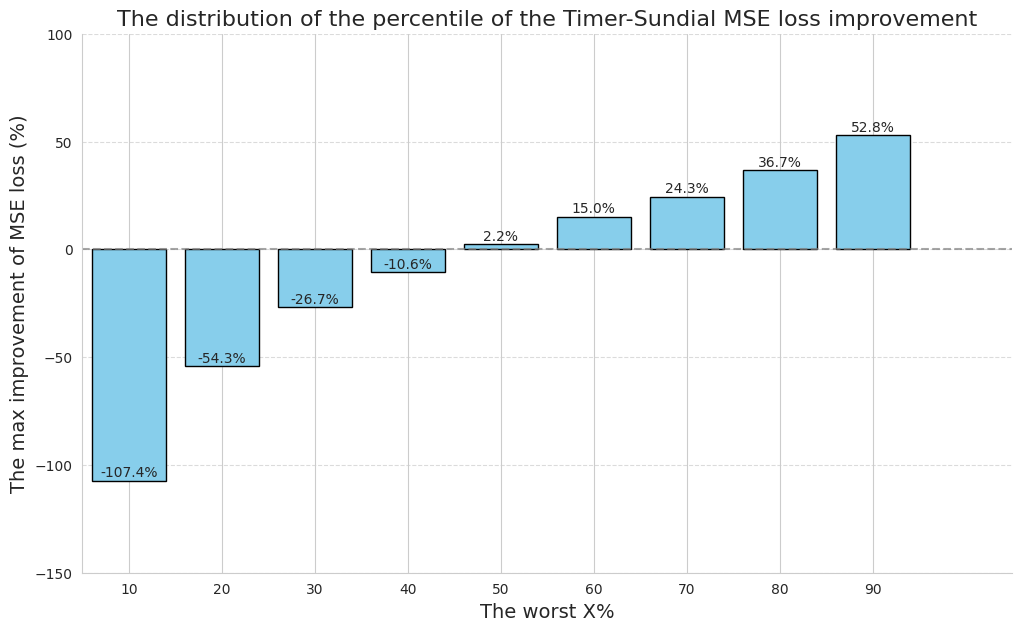

In [26]:
import numpy as np
import seaborn as sns

improvement_values = np.array(mse_improve_list)

quantiles = np.arange(90, -1, -10)
percentile_labels = 100 - quantiles
percentile_values = np.percentile(improvement_values, quantiles)

sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))

bars = plt.bar(
    quantiles, percentile_values, width=8, color="skyblue", edgecolor="black"
)
for bar, q, val in zip(bars, quantiles, percentile_values):
    if val < -150:
        continue
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 0.5,
        f"{val:.1f}%",
        ha="center",
        va="bottom",
        fontsize=10,
    )

plt.axhline(y=0, color="gray", linestyle="--", alpha=0.7)

plt.title(
    "The distribution of the percentile of the Timer-Sundial MSE loss improvement",
    fontsize=16,
)
plt.xlabel("The worst X%", fontsize=14)
plt.ylabel("The max improvement of MSE loss (%)", fontsize=14)
plt.ylim(-150, 100)
plt.grid(True, linestyle="--", alpha=0.7, axis="y")
plt.xticks(quantiles)
plt.xlim(5, 105)


sns.despine()
plt.show()